In [1]:
import sys
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import keras
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

In [2]:
cleveland = pd.read_csv('../input/heart-disease-uci/heart.csv')

In [3]:
print( 'Shape of DataFrame: {}'.format(cleveland.shape))
print (cleveland.loc[1])

Shape of DataFrame: (303, 14)
age          37.0
sex           1.0
cp            2.0
trestbps    130.0
chol        250.0
fbs           0.0
restecg       1.0
thalach     187.0
exang         0.0
oldpeak       3.5
slope         0.0
ca            0.0
thal          2.0
target        1.0
Name: 1, dtype: float64


In [4]:
"""cp: chest pain type
-- Value 0: asymptomatic
-- Value 1: atypical angina
-- Value 2: non-anginal pain
-- Value 3: typical angina
 
restecg: resting electrocardiographic results
-- Value 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
-- Value 1: normal
-- Value 2: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
 
slope: the slope of the peak exercise ST segment
0: downsloping; 1: flat; 2: upsloping
 
thal
Results of the blood flow observed via the radioactive dye.
 
Value 0: NULL (dropped from the dataset previously)
Value 1: fixed defect (no blood flow in some part of the heart)
Value 2: normal blood flow
Value 3: reversible defect (a blood flow is observed but it is not normal)
This feature and the next one are obtained through a very invasive process for the patients. But, by themselves, they give a very good indication of the presence of a heart disease or not.
target : 0 = disease, 1 = no disease"""
cleveland.loc[280:]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
280,42,1,0,136,315,0,1,125,1,1.8,1,0,1,0
281,52,1,0,128,204,1,1,156,1,1.0,1,0,0,0
282,59,1,2,126,218,1,1,134,0,2.2,1,1,1,0
283,40,1,0,152,223,0,1,181,0,0.0,2,0,3,0
284,61,1,0,140,207,0,0,138,1,1.9,2,1,3,0
285,46,1,0,140,311,0,1,120,1,1.8,1,2,3,0
286,59,1,3,134,204,0,1,162,0,0.8,2,2,2,0
287,57,1,1,154,232,0,0,164,0,0.0,2,1,2,0
288,57,1,0,110,335,0,1,143,1,3.0,1,1,3,0
289,55,0,0,128,205,0,2,130,1,2.0,1,1,3,0


In [5]:
data = cleveland[~cleveland.isin(['?'])]
data.loc[280:]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
280,42,1,0,136,315,0,1,125,1,1.8,1,0,1,0
281,52,1,0,128,204,1,1,156,1,1.0,1,0,0,0
282,59,1,2,126,218,1,1,134,0,2.2,1,1,1,0
283,40,1,0,152,223,0,1,181,0,0.0,2,0,3,0
284,61,1,0,140,207,0,0,138,1,1.9,2,1,3,0
285,46,1,0,140,311,0,1,120,1,1.8,1,2,3,0
286,59,1,3,134,204,0,1,162,0,0.8,2,2,2,0
287,57,1,1,154,232,0,0,164,0,0.0,2,1,2,0
288,57,1,0,110,335,0,1,143,1,3.0,1,1,3,0
289,55,0,0,128,205,0,2,130,1,2.0,1,1,3,0


In [6]:
#drop rows with not a number values
data = data.dropna(axis=0)
data.loc[280:]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
280,42,1,0,136,315,0,1,125,1,1.8,1,0,1,0
281,52,1,0,128,204,1,1,156,1,1.0,1,0,0,0
282,59,1,2,126,218,1,1,134,0,2.2,1,1,1,0
283,40,1,0,152,223,0,1,181,0,0.0,2,0,3,0
284,61,1,0,140,207,0,0,138,1,1.9,2,1,3,0
285,46,1,0,140,311,0,1,120,1,1.8,1,2,3,0
286,59,1,3,134,204,0,1,162,0,0.8,2,2,2,0
287,57,1,1,154,232,0,0,164,0,0.0,2,1,2,0
288,57,1,0,110,335,0,1,143,1,3.0,1,1,3,0
289,55,0,0,128,205,0,2,130,1,2.0,1,1,3,0


In [7]:
print(data.shape)
print(data.dtypes)

(303, 14)
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


In [8]:
#transform data to numeric
data = data.apply(pd.to_numeric)

In [9]:
data.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [10]:
#print data characteristics
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


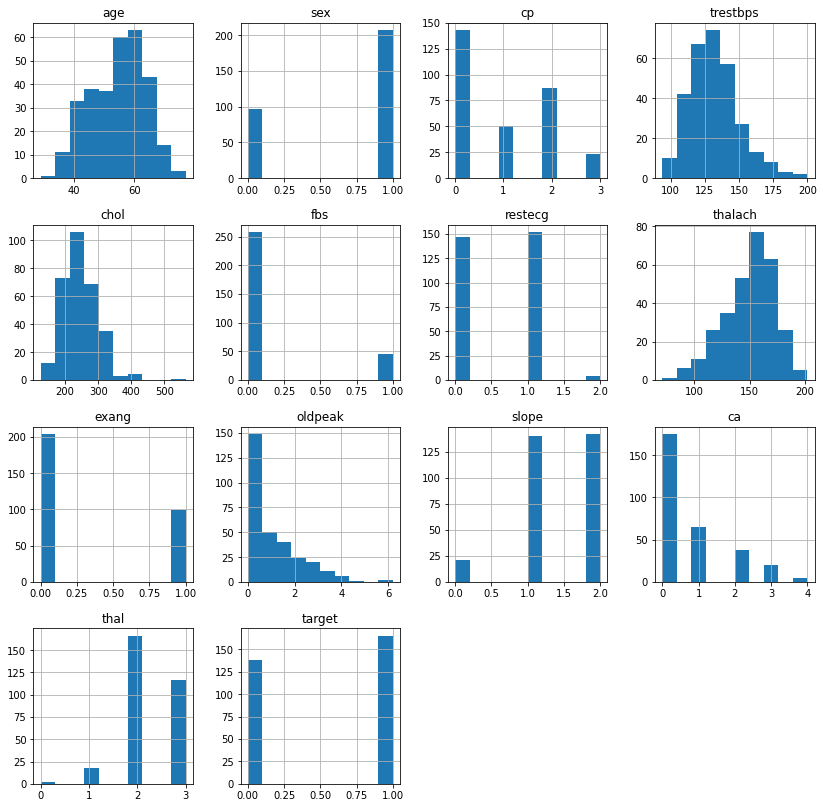

In [11]:
data.hist(figsize = (14,14))
plt.show()

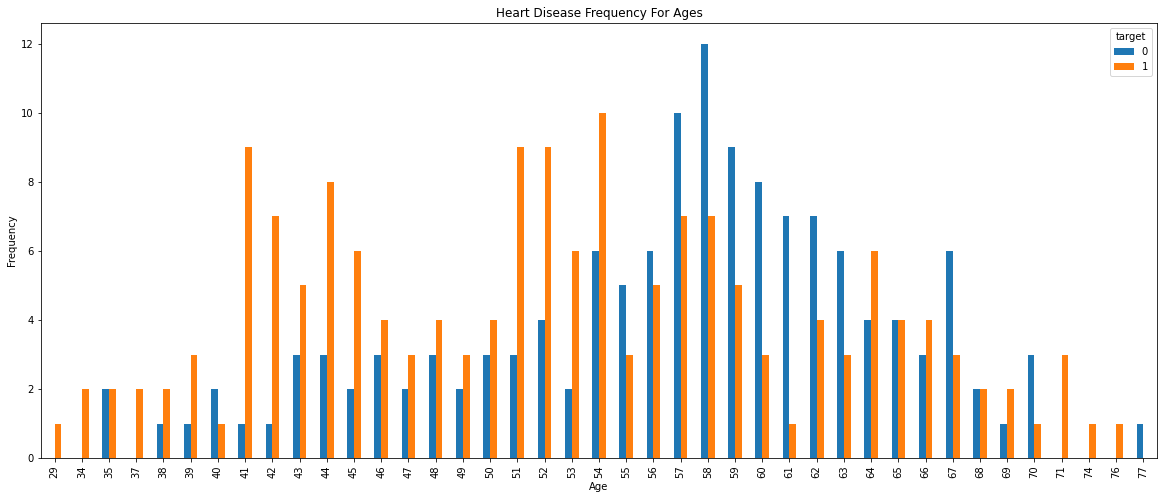

In [12]:
pd.crosstab(data.age, data.target).plot(kind = "bar", figsize = (20,8))
plt.title('Heart Disease Frequency For Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

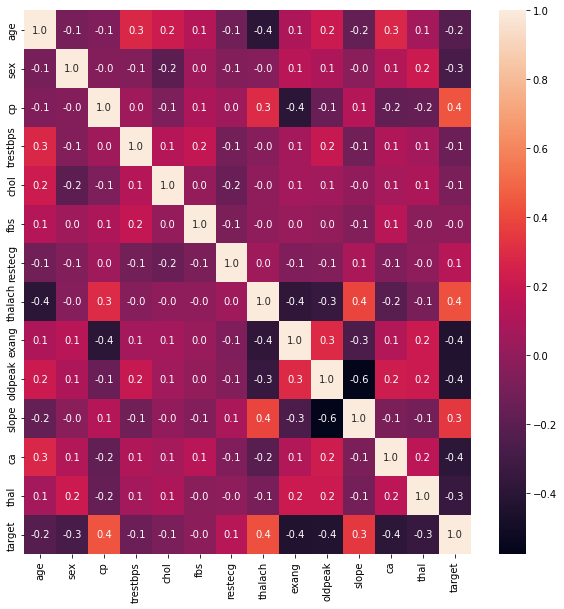

In [13]:
plt.figure(figsize = (10,10))
sns.heatmap(data.corr(), annot=True, fmt='.1f')
plt.show()

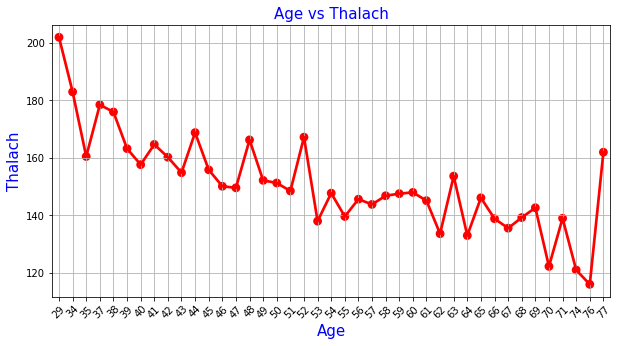

In [14]:
age_unique=sorted(data.age.unique())
age_thalach_values=data.groupby('age')['thalach'].count().values
mean_thalach=[]
for i,age in enumerate(age_unique):
    mean_thalach.append(sum(data[data['age']==age].thalach)/age_thalach_values[i])
    
plt.figure(figsize=(10,5))
sns.pointplot(x=age_unique,y=mean_thalach,color='red',alpha=0.8)
plt.xlabel('Age',fontsize = 15,color='blue')
plt.xticks(rotation=45)
plt.ylabel('Thalach',fontsize = 15,color='blue')
plt.title('Age vs Thalach',fontsize = 15,color='blue')
plt.grid()
plt.show()

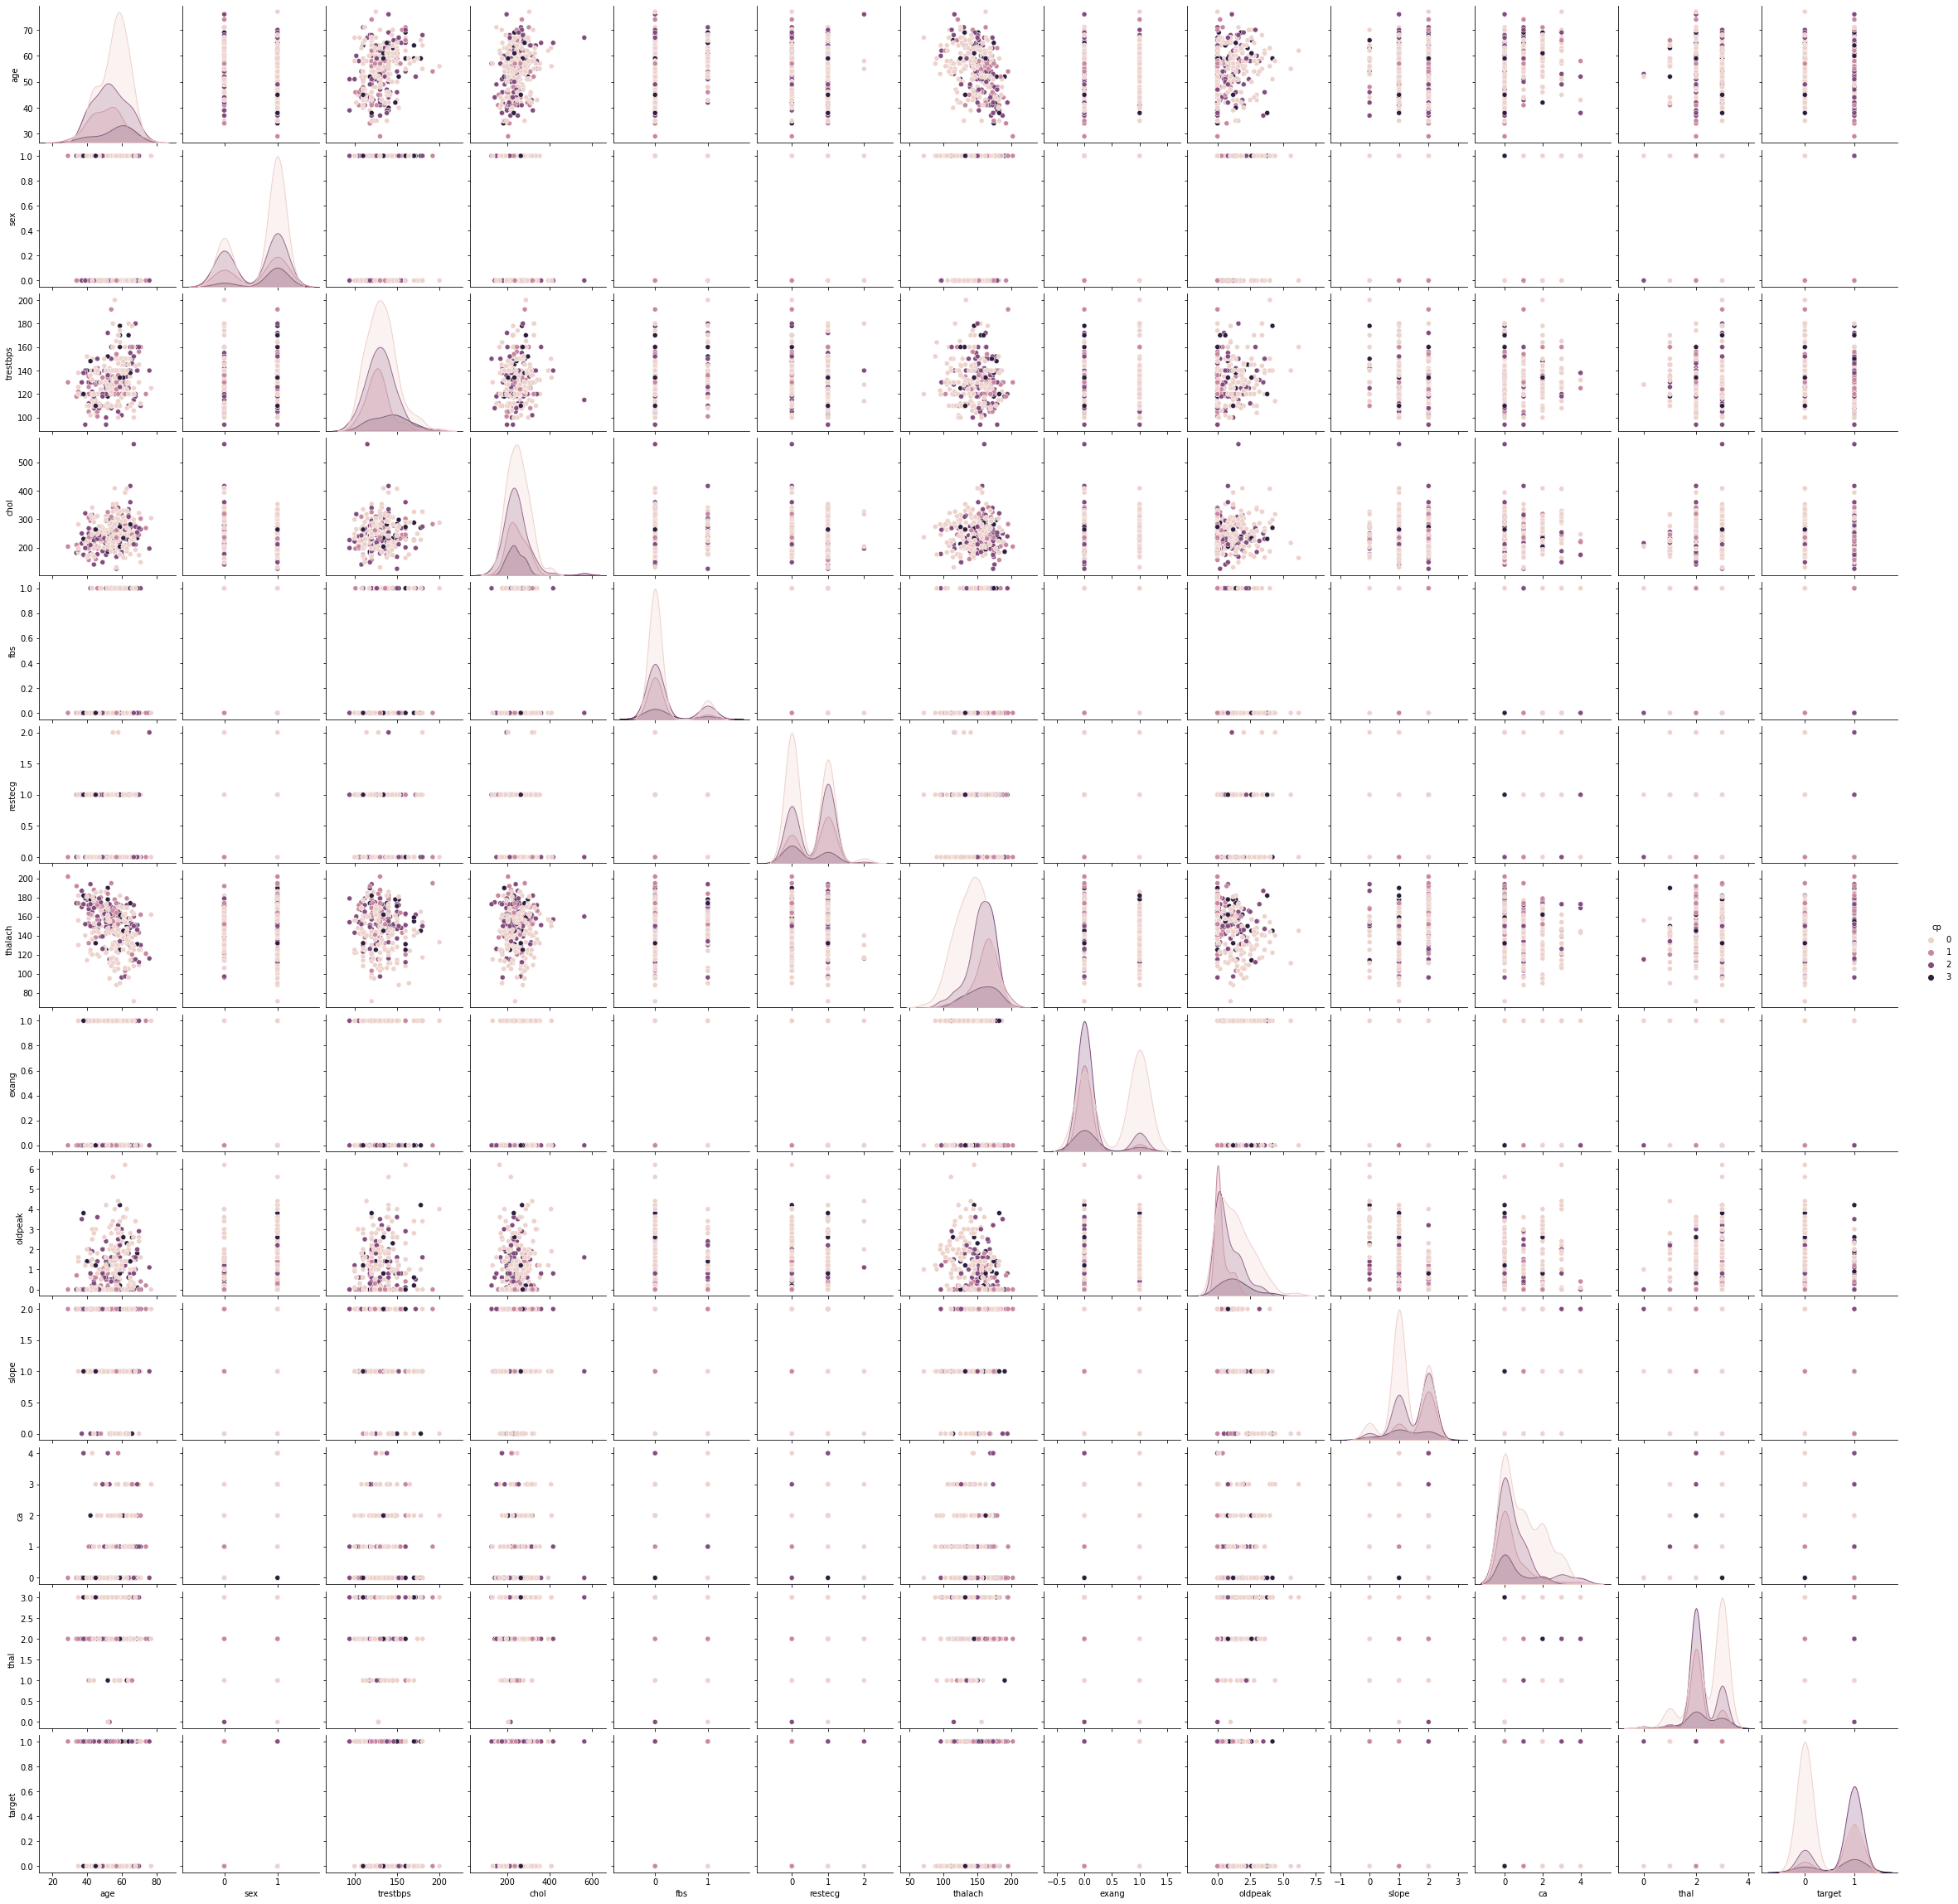

In [15]:
sns.pairplot(data,hue='cp')

In [16]:
X = np.array(data.drop(['target'], axis = 1))
y = np.array(data['target'])

In [17]:
X[0]

array([ 63. ,   1. ,   3. , 145. , 233. ,   1. ,   0. , 150. ,   0. ,
         2.3,   0. ,   0. ,   1. ])

In [18]:
mean = X.mean(axis=0)
X -= mean
std = X.std(axis=0)
X /= std

In [19]:
X[0]

array([ 0.9521966 ,  0.68100522,  1.97312292,  0.76395577, -0.25633371,
        2.394438  , -1.00583187,  0.01544279, -0.69663055,  1.08733806,
       -2.27457861, -0.71442887, -2.14887271])

In [20]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

In [21]:
#convert data to categorical labels
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train, num_classes = None)
Y_test = to_categorical(y_test, num_classes = None)
print(Y_train.shape)
print(Y_train[:10])

(242, 2)
[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [22]:
X_train[0]

array([ 1.61392956, -1.46841752,  1.97312292,  0.47839125, -0.14038081,
       -0.41763453,  0.89896224,  0.05917329, -0.69663055,  0.65599028,
        0.97635214,  1.24459328, -0.51292188])

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras import regularizers

In [24]:
#function to create model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=13, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(2, activation='softmax'))
    
    # compile model
    adam = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model = create_model()

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 378
Trainable params: 378
Non-trainable params: 0
_________________________________________________________________
None


2022-01-17 17:22:56.169952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 17:22:56.278550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 17:22:56.279284: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-17 17:22:56.280435: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [25]:
history=model.fit(X_train, Y_train, validation_data=(X_test, Y_test),epochs=50, batch_size=10)

2022-01-17 17:22:58.845564: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
25/25 [==============================] - 2s 11ms/step - loss: 0.6752 - accuracy: 0.5455 - val_loss: 0.6541 - val_accuracy: 0.5410
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6291 - accuracy: 0.5785 - val_loss: 0.6132 - val_accuracy: 0.6230
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5827 - accuracy: 0.6612 - val_loss: 0.5745 - val_accuracy: 0.7213
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5556 - accuracy: 0.7769 - val_loss: 0.5458 - val_accuracy: 0.7869
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5168 - accuracy: 0.8140 - val_loss: 0.5241 - val_accuracy: 0.7869
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4949 - accuracy: 0.8388 - val_loss: 0.5064 - val_accuracy: 0.7869
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4791 - accuracy: 0.8471 - val_loss: 0.4916 - val_accuracy: 0.8197
Epoch 8/50
25/25 [=

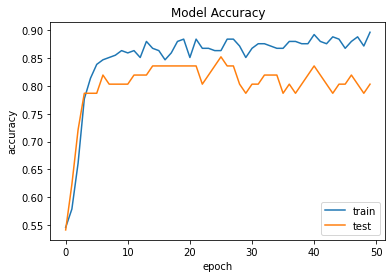

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

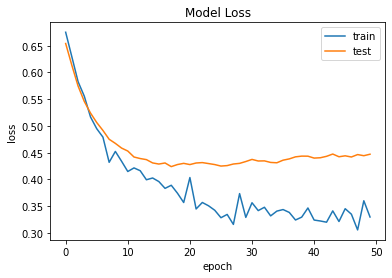

In [27]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [28]:
# convert into binary classification problem - heart disease or no heart disease
Y_train_binary = y_train.copy()
Y_test_binary = y_test.copy()

Y_train_binary[Y_train_binary > 0] = 1
Y_test_binary[Y_test_binary > 0] = 1

print(Y_train_binary[:20])

[1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 1 0 0 1 1]


In [29]:
# define a new keras model for binary classification
def create_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=13, kernel_initializer='normal',  kernel_regularizer=regularizers.l2(0.001),activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8, kernel_initializer='normal',  kernel_regularizer=regularizers.l2(0.001),activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    adam = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

binary_model = create_binary_model()

print(binary_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                224       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
# fit the binary model on the training data
history=binary_model.fit(X_train, Y_train_binary, validation_data=(X_test, Y_test_binary), epochs=50, batch_size=10)

Epoch 1/50
25/25 [==============================] - 1s 9ms/step - loss: 0.6738 - accuracy: 0.7438 - val_loss: 0.6577 - val_accuracy: 0.7705
Epoch 2/50
25/25 [==============================] - 0s 4ms/step - loss: 0.6315 - accuracy: 0.8058 - val_loss: 0.6163 - val_accuracy: 0.8197
Epoch 3/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5900 - accuracy: 0.8388 - val_loss: 0.5747 - val_accuracy: 0.7869
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 0.5443 - accuracy: 0.8430 - val_loss: 0.5364 - val_accuracy: 0.8197
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4908 - accuracy: 0.8512 - val_loss: 0.4979 - val_accuracy: 0.8197
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4784 - accuracy: 0.8306 - val_loss: 0.4725 - val_accuracy: 0.8197
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4376 - accuracy: 0.8471 - val_loss: 0.4498 - val_accuracy: 0.8033
Epoch 8/50
25/25 [==

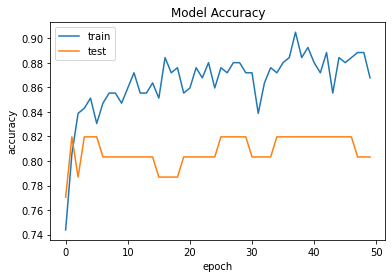

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
# Model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

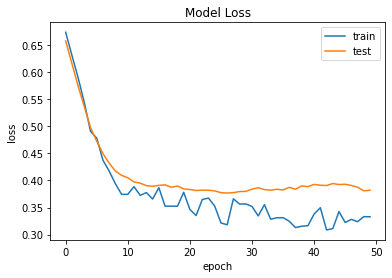

In [32]:
# Model Losss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [33]:
# generate classification report using predictions for categorical model
from sklearn.metrics import classification_report, accuracy_score

categorical_pred = np.argmax(model.predict(X_test), axis=1)

print('Results for Categorical Model')
print(accuracy_score(y_test, categorical_pred))
print(classification_report(y_test, categorical_pred))

Results for Categorical Model
0.8032786885245902
              precision    recall  f1-score   support

           0       0.81      0.75      0.78        28
           1       0.80      0.85      0.82        33

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



In [34]:
# generate classification report using predictions for binary model
from sklearn.metrics import classification_report, accuracy_score
# generate classification report using predictions for binary model 
binary_pred = np.round(binary_model.predict(X_test)).astype(int)

print('Results for Binary Model')
print(accuracy_score(Y_test_binary, binary_pred))
print(classification_report(Y_test_binary, binary_pred))

Results for Binary Model
0.8032786885245902
              precision    recall  f1-score   support

           0       0.86      0.68      0.76        28
           1       0.77      0.91      0.83        33

    accuracy                           0.80        61
   macro avg       0.82      0.79      0.80        61
weighted avg       0.81      0.80      0.80        61

